In [138]:
# -*- coding: utf-8 -*-
"""vrp_dqn.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1iothquIlGtKKte5KIxO-YCKzXnZGjbK-
"""
# !pip install tsplib95==0.6.1

from tqdm import tqdm
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from matplotlib import style
import tsplib95
import networkx as nx
import pickle

import time
import math
import re
import random
import copy

import tensorflow
if tensorflow.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tensorflow.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

from tensorflow.python.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from tensorflow.python.keras import Sequential
# from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras.optimizers import Adam
from collections import deque

import io # to save the image
import math

Default GPU Device: /device:GPU:0


In [139]:
# https://stackoverflow.com/questions/57301698/how-to-change-a-learning-rate-for-adam-in-tf2https://stackoverflow.com/questions/57301698/how-to-change-a-learning-rate-for-adam-in-tf2
class LearningRateReducerCb(tensorflow.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        # old_lr = self.model.optimizer.lr.read_value()
        # new_lr = old_lr * 0.99
        new_lr = 0.01
        # print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
        self.model.optimizer.lr.assign(new_lr)

In [140]:
# 6. Define the movement restriction of the truck.
class Truck:
    def __init__(self, capacity, id, color):
        self.id = id
        self.color = color
        self.path = [] #this has the list of nodes it has visited
        self.max_truck_capacity = copy.deepcopy(capacity) #the max capacity
        self.capacity = copy.deepcopy(capacity)
        #self.visit_depo()
        self.prev_node = None
        self.node = 1 #starts from the depo

    def action(self, choice):
        # the number of choice of actions are the number of nodes-1
        # the choice to be taken depends on the demands - penalty based
        # the choice number is the same as the node number
        # it is not a choice if the demand is 0 - changing this to penalty
        #!! Want the system to learn instead
        # if self.capacity == 0:
        #     self.visit_depo()
        self.move(choice)

    def move(self, to_node_value):
        # node_list_copy = copy.deepcopy(node_list)
        # node_list_copy.remove(1)
        # select a random node to go to
        #if not to_node_value: #to_node_value is False by default
        #    to_node_value = random.choice(self.node_list)
        if to_node_value == 1:
            self.visit_depo()
        self.prev_node = self.node
        self.node = to_node_value
        self.path.append(to_node_value)
        # when invoked update the demand of the node
        # update the demand of the node

    def visit_depo(self):
        self.prev_node = self.node
        self.node = 1 #here it is 1
        self.capacity = copy.deepcopy(self.max_truck_capacity) #truck capacity reset
        self.path.append(1)
    
    #def path(self, node_value):
    #    self.path.append(node_value)

    # def get_node(self):
    #     return self.node

    
    # def get_capacity(self):
    #     return self.capacity


In [164]:
class VRPEnvironment:
    # environment related constants
    #https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.figure.html
    # observation_space = (640,480,3)
    # observation_space = (100,100,3)
    # observation_space = (10,10,3)
    observation_space = (5,5,3)
    # penalty and rewards
    non_positive_capacity_penalty = 100
    zero_demand_penalty = 100 #truck goes to a zero demand node - except 1
    # ignore the failing task penalty as the episode will end only when...
    # all the demands are satisfied i.e. task will always be success...
    # The penalty of the achievement needs to go down.
    failing_task_penalty = 100 #trucks fail to complete the task
    completion_reward = 5000 #trucks complete the task
    demand_satisfying_reward = 100 #another incentive to hit the right target. Imp with considering each step
    hopping_incentive_penalty = 500 #staying at the same node
    # visit_correct_node_reward = 100
    # exploration settings
    permitted_path_length = 5 #30
    epsilon = 1
    epsilon_decay = 0.999#changing this from 0.999
    min_epsilon = 0.001 #0.001
    no_of_episodes = 20_000 #30_000
    # from 0 to 0.5 difference is small so using 1 first
    truck_colors = {
        1:(0,0,1),
        2:(0,1,0),
        3:(1,0,0),
        4:(0,0.5,0.5),
        5:(0.5,0,0.5),
        6:(0.5,0.5,0),
        7:(0.5,0.5,0.5),
        8:(0.5,0.5,1),
        9:(0.5,1,0.5),
        10:(1,0.5,0.5)
    }
    return_images = True
    image_size = 5 #100

    def __init__(self):
        # 1. Extract the tsplib95 file problem
        # self.problem = tsplib95.load_problem('/content/drive/My Drive/HW Assignments/Sem 2/ADBI/Vrp-All/A/A-n32-k5.vrp')
        # self.problem = tsplib95.load_problem('/content/drive/My Drive/HW Assignments/Sem 2/ADBI/Vrp-All/_singleTruck/A-n32-k5_2.vrp')
        self.problem = tsplib95.load_problem('Vrp-All/_singleTruck/A-n32-k5_4.vrp')        
        # 2. Create a networkx graph out of the problem. //will be plotting this
        self.nx_graph = self.problem.get_graph()
        self.edge_list = list(self.problem.get_edges()) #[(,)]
        self.node_positions = self.problem.node_coords #dict
        # the list of nodes
        self.node_list = list(self.problem.get_nodes())
        self.action_space = len(self.node_list) #the number of choices including staying put
        # the depot location
        self.depot_location = 1
        # reseting the environment when initialized
        self.reset_environment()
        
    def reset_environment(self):
        # creating the Trucks
        # 4. Extract the necessary data about the trucks. //no of trucks, depot_section, capacity
        self.node_demands = copy.deepcopy(self.problem.demands)
        truck_capacity = copy.deepcopy(self.problem.capacity)
        self.truck = Truck(truck_capacity, 1, self.truck_colors.get(3))
        self.episode_step = 0
        if self.return_images:
            observation = np.array(self.get_image())

        # there is no else case as we need always need the image for CNN
        return observation
    
    # change the demand of the node when visited
    def change_demand(self, node):
        self.node_demands[node] = 0

    def step(self, action):
        self.episode_step += 1
        # moving the trucks for the action
        self.truck.action(action)
        self.truck.capacity -= self.node_demands.get(action)
        self.change_demand(action)
        # other truck actions

        if self.return_images:
            new_observation = np.array(self.get_image())
        # there is no else case as the return image is always true

        # assinging the rewards and penalties
        self.reward = 0
        # checking if the demands have been satisfied
        completed = False
        if sum(list(self.node_demands.values())) == 0:
            print("***Satisfied***")
            # print(self.node_demands)
            completed = True
            self.reward = self.completion_reward
        else:
            # rewards for other trucks
            self.node_penalty(self.truck) #other penalties
            self.movement_penalty(self.truck) #edge weight
            # penalties for other trucks
        done = False
        if self.reward == self.completion_reward or len(self.truck.path) >= self.permitted_path_length:
        # if self.reward == self.completion_reward:
            done = True
            if sum(list(self.node_demands.values())) > 0:
                self.reward -= self.failing_task_penalty

        return new_observation, self.reward, done, completed

    def node_penalty(self, truck):
        if self.node_demands[truck.node] == 0:
            if (truck.node == 1 and truck.capacity == truck.max_truck_capacity) or truck.node!=1:
                self.reward -= self.zero_demand_penalty
        else:
            self.reward += self.demand_satisfying_reward

        if self.truck.capacity <= 0:
            self.reward -= self.non_positive_capacity_penalty
        # return self.reward

    def movement_penalty(self, truck):
        if truck.prev_node: #else it's 0
            source_node = truck.prev_node
            destination_node = truck.node
            if source_node == destination_node: #if truck stays at the same place
                self.reward -= self.hopping_incentive_penalty
            self.reward -= self.problem.wfunc(source_node, destination_node)
            
    def get_zero_demand_nodes(self, node_demands):
        zero_demand_nodes_list = []
        for key in node_demands:
            if node_demands[key] == 0 and key != 1:
                zero_demand_nodes_list.append(key)
        return zero_demand_nodes_list

    def get_image(self):
        # the initiated rgb image of the given size. 
        env = np.zeros((self.image_size, self.image_size, 3), dtype=np.uint8) #background is black
        #env = np.zeros((1, 5, 3), dtype=np.uint8) #background is black
        for node in self.node_positions.keys():
            node_coods = self.node_positions.get(node)
            env[int(node_coods[0])][int(node_coods[1])] = (0,255,0) #nodes are green
        
        node_coods = self.node_positions.get(1)
        env[int(node_coods[0])][int(node_coods[1])] = (0,0,0) #depot is black
        
        if self.truck.path: #if there are elements in the path
            for visited_node in set(self.truck.path):
                node_coods = self.node_positions.get(visited_node)
                env[int(node_coods[0])][int(node_coods[1])] = (255,255,255) #visited nodes are white
        zero_demand_nodes = self.get_zero_demand_nodes(self.node_demands)
        if zero_demand_nodes:
            for node in zero_demand_nodes:
                node_coods = self.node_positions.get(node)
                env[int(node_coods[0])][int(node_coods[1])] = (255,0,0) #danger are red
        
        node_coods = self.node_positions.get(self.truck.node)
        env[int(node_coods[0])][int(node_coods[1])] = (255,255,0) #truck position
        
        img = Image.fromarray(env, 'RGB')
        # trying to reduce to size to decrease the time taken
        #img = img.resize((10,10))
        return img
    
    def render(self):
        img = self.get_image()
        img = img.resize((300,300))
        cv2.imshow("image", np.array(img))
        cv2.waitKey(1)
    

In [165]:
class DQNAgent:
    def __init__(self):
        # main model
        self.main_model = self.create_model()
        
        # target model
        self.target_model = self.create_model()
        self.target_model.set_weights(self.main_model.get_weights())

        # an array with last n steps for training
        self.replay_memory = deque(maxlen=considering_training_length)
        # self.replay_memory = [] #removing the limit

        # used to know when to update target n/w with main n/w's weights
        self.target_update_counter = 0
        
    def create_model(self):
        model = Sequential()

        # model.add(Conv2D(256, (10,10), input_shape=environment.observation_space))
        model.add(Conv2D(256, (2,2), input_shape=environment.observation_space))
        model.add(Activation('relu'))
        # model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(MaxPooling2D(pool_size=(1,1)))
        model.add(Dropout(0.2))

        # model.add(Conv2D(256,(10,10)))
        model.add(Conv2D(256,(3,3)))
        model.add(Activation('relu'))
        # model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.2))

        # converting the 3D features into the 1D feature
        model.add(Flatten())
        model.add(Dense(64))

        model.add(Dense(environment.action_space, activation='linear'))
        model.compile(loss='mse', optimizer='Adam', metrics=['accuracy'])

        return model

    # adding the step data into the array to be considered later
    def update_replay_memory(self, step):
        self.replay_memory.append(step)

    """        
    def consider_reward(self, element):
        return element[1]
        
    def get_max_rewarded_steps(self, replay_memory, length):
        #replay_memory has the steps and steps[2] is the rewards
        # max = -math.inf
        step_reward_pairs = []
        for step in replay_memory:
            if len(step_reward_pairs) <= length:
                step_reward_pairs.append((step, step[2]))
            else:
                step_reward_pairs.sort(reverse=True, key=self.consider_reward)
                if step_reward_pairs[-1][1] < step[2]:
                    step_reward_pairs.pop() #removing the least value i.e. the last value
                    step_reward_pairs.append((step, step[2]))
        steps_list = []
        for step_reward_pair in step_reward_pairs:
            steps_list.append(step_reward_pair[0])
        return steps_list
    """    
    def train(self, terminal_state, step):
        # start training only when we have a certain number of samples already saved
        if len(self.replay_memory)< min_replay_memory_size:
            return
        # get the minibatch of the samples from the replay table - OLD
        minibatch = random.sample(self.replay_memory, min_training_length)
        # get the minibatch of the samples that have the highest reward
        #minibatch = self.get_max_rewarded_steps(self.replay_memory, min_training_length)
        
        # get current states from minibatch, then query NN model for Q values
        current_states = np.array([transition[0] for transition in minibatch])/255
        current_qs_list = self.main_model.predict(current_states)
        #print(current_qs_list)

        # get future states from the minibatch, then query NN model for Q values
        new_current_states = np.array([transition[3] for transition in minibatch])/255
        future_qs_list = self.target_model.predict(new_current_states)

        X = []
        y = []
        
        # enumerating through the batches
        for index,(current_state, action, reward, new_current_state, done) in enumerate(minibatch):
            # if its not a terminal state, get new q from future states or else set to 0
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + discount*max_future_q
            else:
                new_q = reward

            # update the q value for given state
            current_qs = current_qs_list[index]
            #print(len(current_qs))
            #-1 because indexing 0-4 and actions from 1-5
            current_qs[action-1] = new_q
            

            # append to the training data
            X.append(current_state)
            y.append(current_qs)
        
        # fit on all samples as one batch
        self.main_model.fit(np.array(X)/255, np.array(y), batch_size=min_training_length, verbose=0, shuffle=False, callbacks=[LearningRateReducerCb()])
        
        # updating the target n/w counter every episode
        if terminal_state:
            self.target_update_counter += 1
        
        # if the counter reaches the required value...
        # update the target n/w with weights of main n/w
        if self.target_update_counter > update_target_every:
            self.target_model.set_weights(self.main_model.get_weights())
            self.target_update_counter = 0
    
    # query the main n/w for q values given the current observation space
    def get_qs(self, state):
        return self.main_model.predict(np.array(state).reshape(-1, *state.shape)/255)[0]
    
    def get_models(self):
        return self.main_model, self.target_model


In [166]:
import os
try:
    os.mkdir('saved_plots')
except:
    print("folder is already there")
    
def plot_this(epsilon_list, rewards_list, path_length_list, environment):
    x_axis = list(range(environment.no_of_episodes))
    x_axis = x_axis[:len(path_length_list)]
    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    x_axis = x_axis[:len(epsilon_list)]
    plt.plot(x_axis,epsilon_list,'r', label='Epsilon (scaled by 1000)')
    plt.plot(x_axis,rewards_list,'g', label='Episode Rewards')
    plt.plot(x_axis,path_length_list,'b', label='Path Length (scaled by 100)')
    plt.legend(loc="upper right")
    plt.xlabel('->Episodes')
    plt.ylabel('->Epsilon*1000, Rewards, Path Length*100')
    plt.text(3000, 3500, f'Epsilon Decaying Factor: {epsilon_decaying_factor}')
    plt.text(3000, 3200, f'Adam learning rate: 0.001')
    plt.title('Epsilon, Rewards, Path Length vs Episodes')

folder is already there


In [167]:
# model related constants
discount = 0.9 #the discount applied to the DQN equation
# the environment keeps running till the demand of the nodes is satisfied
considering_training_length = 50_000 #the no of steps considered for training
min_training_length = 100 #the no of steps used for training
# episodes = 30_000
update_target_every = 5 #terminal states (end of episodes)
min_replay_memory_size = 1000 #min no of steps in a memory to start training

environment = VRPEnvironment()
agent = DQNAgent()

In [ ]:
show_preview = False #using this will make it slow. Don't care about this now.
aggregrate_stats_every = 50
start_decaying = True #making this True ignores the conditional decaying - Notes 2.a

x_axis = list(range(environment.no_of_episodes+1))
epsilon_list = []
rewards_list = []
path_length_list = []

epsilon_decaying_factor = 3000

plot_rep = 1000

# iterate over the episodes
for episode in tqdm(range(1, environment.no_of_episodes + 1), ascii=True, unit='episodes'):
    #print(episode)
    # Restarting episode - reset episode reward and step number
    episode_reward = 0
    step = 1
    # Reset environment and get initial state
    current_state = environment.reset_environment()
    # Reset flag and start iterating until episode ends
    done = False
    while not done:
        # This part stays mostly the same, the change is to query a model for Q values
        if np.random.random() > environment.epsilon:
            # Get action from Q table            
            action = np.argmax(agent.get_qs(current_state))+1
            #print("++"+str(action))
        else:
            # Get random action
            action = np.random.randint(1, environment.action_space+1)
            #print("**"+str(action))

#         if action != 0: #JUST IGNORING 0. MIGHT BE STUPID!
        #try:
        new_state, reward, done, completed = environment.step(action)
        #except:
        #    print(action)
        #    raise
        # Transform new continous state to new discrete state and count reward
        episode_reward += reward
        
        # no rendering
        if show_preview and not episode % aggregrate_stats_every:
            environment.render()
        
        # Every step we update replay memory and train main network
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(done, step)
        current_state = new_state
        step += 1

        # Decay the Epsilon
        if completed:
            start_decaying = True
        
        if start_decaying:
            # environment.epsilon = 0.001
            if environment.epsilon > environment.min_epsilon:
                # environment.epsilon *= environment.epsilon_decay
                environment.epsilon = np.exp(-episode/epsilon_decaying_factor)
                environment.epsilon = max(environment.min_epsilon, environment.epsilon)
        # print(".",end="")
        
        #if episode%plot_rep == 0:
        #    plot_this(epsilon_list, rewards_list, path_length_list, environment)
        #    plt.savefig(f'saved_plots/plot_{epsilon_decaying_factor}_min_eps_{environment.min_epsilon}_lr_0.001_discount_{discount}.png')
        
    epsilon_list.append(environment.epsilon*1000)
    rewards_list.append(episode_reward)
    path_length_list.append(len(environment.truck.path)*100)
    
    print("Path is:", end=" ")
    print(environment.truck.path, end=";")
    print("P and R: "+str(episode_reward), end=";")
    print("Capacity: "+str(environment.truck.capacity), end=";")
    print("Epsilon: "+str(environment.epsilon))







  0%|                                                                                  | 0/20000 [00:00<?, ?episodes/s]





  0%|1                                                                       | 34/20000 [00:00<01:22, 241.92episodes/s]

Path is: [2, 4, 4, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.9996667222160499
Path is: [5, 3, 3, 5, 2];P and R: -1116;Capacity: 20;Epsilon: 0.9993335555061811
Path is: [4, 4, 3, 3, 5];P and R: -1608;Capacity: 30;Epsilon: 0.999000499833375
Path is: [1, 1, 3, 5, 4];P and R: -1007;Capacity: 30;Epsilon: 0.9986675551606254
Path is: [1, 1, 3, 5, 3];P and R: -1009;Capacity: 50;Epsilon: 0.9983347214509387
Path is: [2, 1, 1, 4, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.9980019986673331
***Satisfied***
Path is: [5, 5, 3, 4, 2];P and R: 4090;Capacity: 0;Epsilon: 0.9976693867728395
Path is: [1, 1, 1, 1, 3];P and R: -1403;Capacity: 50;Epsilon: 0.9973368857305009
Path is: [3, 3, 4, 5, 3];P and R: -1108;Capacity: 30;Epsilon: 0.997004495503373
Path is: [1, 1, 5, 3, 5];P and R: -1012;Capacity: 50;Epsilon: 0.9966722160545233
Path is: [1, 1, 1, 1, 4];P and R: -1404;Capacity: 80;Epsilon: 0.9963400473470321
Path is: [3, 3, 1, 1, 3];P and R: -1506;Capacity: 100;Epsilon: 0.9960079893439915
***Satisfi







  0%|2                                                                       | 67/20000 [00:00<01:22, 242.06episodes/s]





  0%|3                                                                       | 93/20000 [00:00<01:20, 246.10episodes/s]

Path is: [2, 2, 5, 5, 3];P and R: -1608;Capacity: 20;Epsilon: 0.9831436846349096
***Satisfied***
Path is: [2, 3, 2, 2, 4];P and R: 4097;Capacity: 0;Epsilon: 0.98281602468639
Path is: [1, 1, 1, 1, 5];P and R: -1406;Capacity: 100;Epsilon: 0.9824884739396519
Path is: [4, 5, 1, 1, 2];P and R: -1006;Capacity: 70;Epsilon: 0.9821610323583008
Path is: [1, 1, 5, 5, 4];P and R: -1507;Capacity: 80;Epsilon: 0.9818336999059541
Path is: [3, 5, 1, 1, 1, 1];P and R: -1506;Capacity: 100;Epsilon: 0.981506476546242
Path is: [1, 1, 5, 3, 4];P and R: -1010;Capacity: 30;Epsilon: 0.981179362242806
Path is: [1, 1, 5, 5, 1, 1];P and R: -2006;Capacity: 100;Epsilon: 0.9808523569593002
Path is: [5, 2, 5, 2, 1, 1];P and R: -1118;Capacity: 100;Epsilon: 0.9805254606593905
Path is: [3, 3, 3, 5, 3];P and R: -1609;Capacity: 50;Epsilon: 0.9801986733067553
***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.9798719948650848
Path is: [2, 1, 1, 1, 1];P and R: -1401;Capacity: 100;Epsilon: 0.9795454252980







  1%|3                                                                      | 112/20000 [00:00<01:37, 204.35episodes/s]







Path is: [5, 5, 2, 2, 4];P and R: -1613;Capacity: 50;Epsilon: 0.9665715046375066
***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.9662493678284118
***Satisfied***
Path is: [2, 5, 4, 2, 3];P and R: 4591;Capacity: 0;Epsilon: 0.9659273383803587
Path is: [4, 3, 5, 1, 1];P and R: -1008;Capacity: 100;Epsilon: 0.9656054162575665
Path is: [5, 2, 2, 3, 2];P and R: -1112;Capacity: 20;Epsilon: 0.965283601424266
***Satisfied***
Path is: [4, 2, 4, 4, 3];P and R: 4090;Capacity: 0;Epsilon: 0.9649618938446999
Path is: [5, 4, 1, 1, 2];P and R: -1008;Capacity: 70;Epsilon: 0.9646402934831231
***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.964318800303802
Path is: [4, 1, 1, 3, 4];P and R: -1008;Capacity: 50;Epsilon: 0.9639974142710154
Path is: [3, 4, 5, 1, 1];P and R: -1005;Capacity: 100;Epsilon: 0.9636761353490535
Path is: [4, 5, 2, 4, 5];P and R: -613;Capacity: 50;Epsilon: 0.9633549635022187
Path is: [5, 4, 4, 4, 5];P and R: -1608;Capacity: 80;Epsilon: 0.96

  1%|4                                                                      | 128/20000 [00:00<01:58, 168.03episodes/s]





  1%|5                                                                      | 144/20000 [00:00<02:00, 164.78episodes/s]

Path is: [5, 3, 1, 1, 2];P and R: -1010;Capacity: 70;Epsilon: 0.9579113900670306
Path is: [4, 2, 5, 2, 5];P and R: -619;Capacity: 50;Epsilon: 0.9575921394817286
***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.9572729952955541
Path is: [2, 1, 1, 4, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.9569539574730467
Path is: [3, 2, 1, 1, 3];P and R: -1007;Capacity: 100;Epsilon: 0.9566350259787578
Path is: [2, 5, 1, 1, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.9563162007772505
Path is: [1, 1, 4, 4, 1, 1];P and R: -2004;Capacity: 100;Epsilon: 0.9559974818331
***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.9556788691108927
Path is: [1, 1, 2, 4, 5];P and R: -1005;Capacity: 50;Epsilon: 0.9553603625752275
Path is: [2, 2, 3, 3, 5];P and R: -1605;Capacity: 20;Epsilon: 0.9550419621907147
Path is: [4, 1, 1, 1, 1];P and R: -1404;Capacity: 100;Epsilon: 0.9547236679219764
Path is: [4, 1, 1, 5, 1, 1];P and R: -1510;Capacity: 100;Epsilon: 0.954405479733646







  1%|5                                                                      | 159/20000 [00:00<02:09, 153.08episodes/s]

***Satisfied***
Path is: [4, 2, 4, 2, 3];P and R: 4587;Capacity: 0;Epsilon: 0.9505954828883969
Path is: [5, 5, 3, 3, 4];P and R: -1610;Capacity: 30;Epsilon: 0.950278670532427
Path is: [1, 1, 5, 3, 3];P and R: -1509;Capacity: 50;Epsilon: 0.9499619637629768
***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.949645362544857
Path is: [3, 1, 1, 5, 5];P and R: -1509;Capacity: 100;Epsilon: 0.9493288668428895
Path is: [4, 3, 3, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.9490124766219084
***Satisfied***
Path is: [5, 2, 3, 4];P and R: 4689;Capacity: 0;Epsilon: 0.9486961918467588
Path is: [2, 3, 2, 5, 1, 1];P and R: -1107;Capacity: 100;Epsilon: 0.9483800124822982
Path is: [2, 3, 2, 2, 3];P and R: -1104;Capacity: 20;Epsilon: 0.9480639384933955
Path is: [2, 3, 1, 1, 5];P and R: -1008;Capacity: 100;Epsilon: 0.9477479698449315
Path is: [3, 2, 2, 3, 2];P and R: -1106;Capacity: 20;Epsilon: 0.9474321065017983
***Satisfied***
Path is: [4, 5, 3, 2];P and R: 4692;Capacity: 0;Epsilon







  1%|6                                                                       | 174/20000 [00:01<03:39, 90.31episodes/s]

Path is: [2, 2, 4, 2, 2];P and R: -1607;Capacity: 50;Epsilon: 0.9449089865395918
Path is: [1, 1, 2, 5, 3];P and R: -1008;Capacity: 20;Epsilon: 0.9445940693665233
Path is: [1, 1, 1, 1, 1, 1];P and R: -1900;Capacity: 100;Epsilon: 0.9442792571483525
Path is: [4, 1, 1, 1, 1];P and R: -1404;Capacity: 100;Epsilon: 0.9439645498501
Path is: [3, 2, 1, 1, 2];P and R: -1005;Capacity: 100;Epsilon: 0.9436499474367985
***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.9433354498734922
Path is: [4, 4, 1, 1, 5];P and R: -1510;Capacity: 100;Epsilon: 0.9430210571252368
Path is:







  1%|6                                                                       | 186/20000 [00:01<03:52, 85.09episodes/s]





  1%|7                                                                       | 201/20000 [00:01<03:28, 94.96episodes/s]

 [1, 1, 2, 5, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.9427067691570997
***Satisfied***
Path is: [2, 3, 5, 4];P and R: 4695;Capacity: 0;Epsilon: 0.9423925859341603
***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.9420785074215092
Path is: [5, 1, 1, 4, 1, 1];P and R: -1510;Capacity: 100;Epsilon: 0.9417645335842487
Path is: [5, 2, 5, 2, 2];P and R: -1118;Capacity: 70;Epsilon: 0.9414506643874929
***Satisfied***
Path is: [2, 5, 4, 5, 3];P and R: 4593;Capacity: 0;Epsilon: 0.9411368997963675
Path is: [4, 3, 1, 1, 3];P and R: -1008;Capacity: 100;Epsilon: 0.9408232397760097
Path is: [1, 1, 2, 1, 1];P and R: -1401;Capacity: 100;Epsilon: 0.9405096842915684
***Satisfied***
Path is: [2, 3, 2, 4];P and R: 4697;Capacity: 0;Epsilon: 0.9401962333082041
Path is: [4, 4, 1, 1, 1, 1];P and R: -2004;Capacity: 100;Epsilon: 0.9398828867910889
***Satisfied***
Path is: [4, 2, 3];P and R: 4793;Capacity: 0;Epsilon: 0.9395696447054066
Path is: [2, 5, 3, 1, 1];P and R: -1008;Capacity: 1







  1%|7                                                                       | 213/20000 [00:01<03:34, 92.08episodes/s]

***Satisfied***
Path is: [4, 1, 1, 2, 3];P and R: 4195;Capacity: 20;Epsilon: 0.9348835215525143
Path is: [5, 1, 1, 2, 5];P and R: -1011;Capacity: 70;Epsilon: 0.9345719456441998
Path is: [2, 3, 5, 2, 1, 1];P and R: -1109;Capacity: 100;Epsilon: 0.9342604735772135
Path is: [5, 5, 5, 4, 1, 1];P and R: -2107;Capacity: 100;Epsilon: 0.9339491053169475
Path is: [3, 5, 1, 1, 2];P and R: -1007;Capacity: 70;Epsilon: 0.9336378408288053
Path is: [1, 1, 3, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.933326680078202
Path is: [5, 2, 1, 1, 2];P and R: -1011;Capacity: 100;Epsilon: 0.933015623030564
Path is: [4, 1, 1, 2, 4];P and R: -1008;Capacity: 70;Epsilon: 0.9327046696513296
Path is: [5, 3, 1, 1, 4];P and R: -1013;Capacity: 80;Epsilon: 0.9323938199059483
Path is: [1, 1, 3, 1, 1];P and R: -1403;Capacity: 100;Epsilon: 0.9320830737598812
Path is: [2, 4, 1, 1, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.9317724311786011
Path is: [4, 3, 1, 1, 1, 1];P and R: -1505;Capacity: 100;Epsilon: 0.9314618921275







  1%|8                                                                       | 224/20000 [00:01<03:43, 88.48episodes/s]





  1%|8                                                                       | 234/20000 [00:01<03:36, 91.26episodes/s]

***Satisfied***
Path is: [2, 4, 5, 3];P and R: 4695;Capacity: 0;Epsilon: 0.9296008300257927
Path is: [3, 1, 1, 4, 3];P and R: -1008;Capacity: 80;Epsilon: 0.9292910147212036
***Satisfied***
Path is: [5, 4, 5, 3, 2];P and R: 4589;Capacity: 0;Epsilon: 0.9289813026711725
Path is: [1, 1, 3, 3, 4];P and R: -1504;Capacity: 30;Epsilon: 0.9286716938412872
***Satisfied***
Path is: [4, 2, 4, 2, 3];P and R: 4587;Capacity: 0;Epsilon: 0.9283621881971466
Path is: [4, 1, 1, 4, 4];P and R: -1508;Capacity: 100;Epsilon: 0.9280527857043611
Path is: [2, 3, 1, 1, 1, 1];P and R: -1502;Capacity: 100;Epsilon: 0.9277434863285529
Path is: [3, 5, 3, 2, 1, 1];P and R: -1110;Capacity: 100;Epsilon: 0.9274342900353552
Path is: [5, 2, 5, 4, 4];P and R: -1115;Capacity: 50;Epsilon: 0.9271251967904128
Path is: [4, 1, 1, 3, 4];P and R: -1008;Capacity: 50;Epsilon: 0.9268162065593822
Path is: [5, 2, 1, 1, 2];P and R: -1011;Capacity: 100;Epsilon: 0.9265073193079311
Path is: [2, 5, 2, 4, 5];P and R: -613;Capacity: 50;Epsilon:







  1%|8                                                                       | 244/20000 [00:01<03:51, 85.19episodes/s]

Path is: [2, 3, 1, 1, 2];P and R: -1003;Capacity: 100;Epsilon: 0.9234241031253715
Path is: [3, 4, 4, 3, 4];P and R: -1106;Capacity: 30;Epsilon: 0.9231163463866358
Path is: [4, 2, 1, 1, 2];P and R: -1008;Capacity: 100;Epsilon: 0.922808692216384
***Satisfied***
Path is: [3, 4, 4, 2];P and R: 4196;Capacity: 0;Epsilon: 0.9225011405804322
Path is: [2, 2, 5, 3, 5];P and R: -1111;Capacity: 20;Epsilon: 0.922193691444608
Path is: [4, 5, 4, 1, 1];P and R: -1006;Capacity: 100;Epsilon: 0.9218863447747506
Path is: [5, 3, 3, 3, 4];P and R: -1610;Capacity: 30;Epsilon: 0.9215791005367102
Path is: [1, 1, 2, 4, 5];P and R: -1005;Capacity: 50;Epsilon: 0.9212719586963487
Path is: [5, 2, 3, 3, 1, 1];P and R: -1611;Capacity: 100;Epsilon: 0.9209649192195389
Path is: [1, 1, 5, 3, 3];P and R: -1509;Capacity: 50;Epsilon: 0.9206579820721656
***Satisfied***
Path is: [3, 1, 1, 4, 2];P and R: 4193;Capacity: 50;Epsilon: 0.9203511472201247
Path is: [2, 2, 5, 3, 5];P and R: -1111;Capacity: 20;Epsilon: 0.92004441462932







  1%|8                                                                     | 254/20000 [00:07<1:01:08,  5.38episodes/s]

Path is: [5, 4, 5, 1, 1];P and R: -1008;Capacity: 100;Epsilon: 0.9188185061970551
Path is: [4, 3, 5, 3, 5];P and R: -614;Capacity: 30;Epsilon: 0.9185122844014574
Path is: [2, 4, 1, 1, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.918206164662781
Path is: [3, 5, 2, 1, 1];P and R: -1010;Capacity: 100;Epsilon: 0.9179001469470129
***Satisfied***
Path is: [5, 2, 3, 4];P and R: 4689;Capacity: 0;Epsilon: 0.917594231220151
Path is: [3, 2, 2, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.9172884174482046
Path is: [3, 1, 1, 5, 1, 1];P and R: -1509;Capacity: 100;Epsilon: 0.9169827055971943








  1%|9                                                                     | 261/20000 [00:11<1:35:30,  3.44episodes/s]

Path is: [1, 1, 3, 2, 2];P and R: -1504;Capacity: 20;Epsilon: 0.9166770956331523
Path is: [3, 3, 2, 3, 3];P and R: -1605;Capacity: 20;Epsilon: 0.9163715875221219
***Satisfied***
Path is: [3, 2, 5, 2, 4];P and R: 4588;Capacity: 0;Epsilon: 0.9160661812301576
Path is: [1, 1, 2, 3, 5];P and R: -1005;Capacity: 20;Epsilon: 0.9157608767233256
Path is: [2, 1, 1, 3, 5];P and R: -1007;Capacity: 50;Epsilon: 0.9154556739677031








  1%|9                                                                     | 266/20000 [00:14<2:05:07,  2.63episodes/s]

Path is: [5, 4, 1, 1, 3];P and R: -1010;Capacity: 50;Epsilon: 0.9151505729293785
Path is: [3, 5, 1, 1, 2];P and R: -1007;Capacity: 70;Epsilon: 0.914845573574452
Path is: [2, 2, 5, 3, 3];P and R: -1608;Capacity: 20;Epsilon: 0.9145406758690345
***Satisfied***
Path is: [3, 4, 2];P and R: 4796;Capacity: 0;Epsilon: 0.9142358797792487








  1%|9                                                                     | 270/20000 [00:16<2:17:19,  2.39episodes/s]

Path is: [2, 3, 2, 3, 2];P and R: -605;Capacity: 20;Epsilon: 0.9139311852712282
Path is: [4, 4, 2, 4, 5];P and R: -1111;Capacity: 50;Epsilon: 0.9136265923111181
Path is: [2, 4, 4, 2, 2];P and R: -1607;Capacity: 50;Epsilon: 0.9133221008650748








  1%|9                                                                     | 273/20000 [00:18<2:38:43,  2.07episodes/s]

***Satisfied***
Path is: [2, 4, 3];P and R: 4796;Capacity: 0;Epsilon: 0.9130177108992658
Path is: [1, 1, 4, 2, 1, 1];P and R: -1507;Capacity: 100;Epsilon: 0.9127134223798701








  1%|9                                                                     | 275/20000 [00:19<2:44:54,  1.99episodes/s]

Path is: [1, 1, 4, 2, 5];P and R: -1011;Capacity: 50;Epsilon: 0.9124092352730778
***Satisfied***
Path is: [1, 1, 2, 3, 4];P and R: 4198;Capacity: 0;Epsilon: 0.9121051495450904








  1%|9                                                                     | 277/20000 [00:20<2:46:28,  1.97episodes/s]

Path is: [5, 1, 1, 5, 2];P and R: -1016;Capacity: 70;Epsilon: 0.9118011651621205








  1%|9                                                                     | 278/20000 [00:21<2:34:59,  2.12episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.9114972820903922








  1%|9                                                                     | 279/20000 [00:21<2:36:48,  2.10episodes/s]

Path is: [3, 3, 1, 1, 3];P and R: -1506;Capacity: 100;Epsilon: 0.9111935002961405








  1%|9                                                                     | 280/20000 [00:22<2:47:42,  1.96episodes/s]

***Satisfied***
Path is: [5, 4, 3, 2];P and R: 4692;Capacity: 0;Epsilon: 0.9108898197456121








  1%|9                                                                     | 281/20000 [00:22<2:40:15,  2.05episodes/s]

Path is: [1, 1, 1, 1, 5];P and R: -1406;Capacity: 100;Epsilon: 0.9105862404050646








  1%|9                                                                     | 282/20000 [00:23<2:38:50,  2.07episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.910282762240767








  1%|9                                                                     | 283/20000 [00:23<2:46:17,  1.98episodes/s]

Path is: [5, 3, 1, 1, 4];P and R: -1013;Capacity: 80;Epsilon: 0.9099793852189993








  1%|9                                                                     | 284/20000 [00:24<2:48:09,  1.95episodes/s]

***Satisfied***
Path is: [5, 4, 2, 3];P and R: 4690;Capacity: 0;Epsilon: 0.9096761093060532








  1%|9                                                                     | 285/20000 [00:24<2:46:21,  1.98episodes/s]

***Satisfied***
Path is: [5, 3, 2, 4];P and R: 4690;Capacity: 0;Epsilon: 0.9093729344682314








  1%|#                                                                     | 286/20000 [00:25<2:57:33,  1.85episodes/s]

Path is: [4, 5, 4, 2, 2];P and R: -1109;Capacity: 50;Epsilon: 0.9090698606718477








  1%|#                                                                     | 287/20000 [00:26<3:30:31,  1.56episodes/s]

Path is: [5, 4, 4, 5, 2];P and R: -1112;Capacity: 50;Epsilon: 0.9087668878832271








  1%|#                                                                     | 288/20000 [00:26<3:18:20,  1.66episodes/s]

Path is: [1, 1, 4, 5, 3];P and R: -1008;Capacity: 30;Epsilon: 0.9084640160687062








  1%|#                                                                     | 289/20000 [00:26<2:56:39,  1.86episodes/s]

***Satisfied***
Path is: [3, 2, 4];P and R: 4796;Capacity: 0;Epsilon: 0.9081612451946324
***Satisfied***








  1%|#                                                                     | 290/20000 [00:27<2:55:10,  1.88episodes/s]

Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.9078585752273646








  1%|#                                                                     | 291/20000 [00:27<2:50:33,  1.93episodes/s]

Path is: [1, 1, 3, 3, 3];P and R: -2003;Capacity: 50;Epsilon: 0.9075560061332727








  1%|#                                                                     | 292/20000 [00:28<2:58:56,  1.84episodes/s]

Path is: [2, 5, 3, 5, 2];P and R: -615;Capacity: 20;Epsilon: 0.907253537878738








  1%|#                                                                     | 293/20000 [00:29<3:15:08,  1.68episodes/s]

Path is: [4, 4, 4, 5, 3];P and R: -1608;Capacity: 30;Epsilon: 0.9069511704301528








  1%|#                                                                     | 294/20000 [00:29<3:10:32,  1.72episodes/s]

Path is: [3, 1, 1, 2, 3];P and R: -1005;Capacity: 70;Epsilon: 0.9066489037539209








  1%|#                                                                     | 295/20000 [00:30<3:12:59,  1.70episodes/s]

Path is: [2, 1, 1, 3, 1, 1];P and R: -1504;Capacity: 100;Epsilon: 0.906346737816457








  1%|#                                                                     | 296/20000 [00:31<3:12:30,  1.71episodes/s]

Path is: [2, 1, 1, 2, 2];P and R: -1502;Capacity: 100;Epsilon: 0.9060446725841872








  1%|#                                                                     | 297/20000 [00:31<3:03:44,  1.79episodes/s]

Path is: [5, 4, 5, 1, 1];P and R: -1008;Capacity: 100;Epsilon: 0.9057427080235485








  1%|#                                                                     | 298/20000 [00:32<3:03:05,  1.79episodes/s]

Path is: [1, 1, 5, 5, 4];P and R: -1507;Capacity: 80;Epsilon: 0.9054408441009895








  1%|#                                                                     | 299/20000 [00:32<3:09:53,  1.73episodes/s]

Path is: [2, 5, 1, 1, 5];P and R: -1011;Capacity: 100;Epsilon: 0.9051390807829696








  2%|#                                                                     | 300/20000 [00:33<3:17:07,  1.67episodes/s]

Path is: [4, 4, 1, 1, 2];P and R: -1505;Capacity: 70;Epsilon: 0.9048374180359595








  2%|#                                                                     | 301/20000 [00:33<3:16:53,  1.67episodes/s]

Path is: [2, 3, 3, 1, 1];P and R: -1502;Capacity: 100;Epsilon: 0.9045358558264415








  2%|#                                                                     | 302/20000 [00:34<3:05:47,  1.77episodes/s]

***Satisfied***
Path is: [4, 5, 2, 3];P and R: 4691;Capacity: 0;Epsilon: 0.9042343941209081








  2%|#                                                                     | 303/20000 [00:34<3:00:07,  1.82episodes/s]

Path is: [5, 1, 1, 4, 3];P and R: -1011;Capacity: 30;Epsilon: 0.9039330328858641








  2%|#                                                                     | 304/20000 [00:35<3:01:38,  1.81episodes/s]

***Satisfied***
Path is: [1, 1, 4, 3, 2];P and R: 4195;Capacity: 0;Epsilon: 0.9036317720878246








  2%|#                                                                     | 305/20000 [00:36<3:15:40,  1.68episodes/s]

***Satisfied***
Path is: [2, 5, 2, 3, 4];P and R: 4590;Capacity: 0;Epsilon: 0.9033306116933163








  2%|#                                                                     | 306/20000 [00:36<3:10:28,  1.72episodes/s]

Path is: [5, 2, 1, 1, 1, 1];P and R: -1510;Capacity: 100;Epsilon: 0.9030295516688768








  2%|#                                                                     | 307/20000 [00:37<3:31:45,  1.55episodes/s]

Path is: [2, 5, 5, 3, 1, 1];P and R: -1608;Capacity: 100;Epsilon: 0.9027285919810552








  2%|#                                                                     | 308/20000 [00:38<3:17:19,  1.66episodes/s]

Path is: [3, 5, 1, 1, 2];P and R: -1007;Capacity: 70;Epsilon: 0.9024277325964113








  2%|#                                                                     | 309/20000 [00:38<3:10:48,  1.72episodes/s]

Path is: [2, 1, 1, 2, 1, 1];P and R: -1502;Capacity: 100;Epsilon: 0.9021269734815165








  2%|#                                                                     | 310/20000 [00:39<3:06:22,  1.76episodes/s]

Path is: [1, 1, 5, 3, 5];P and R: -1012;Capacity: 50;Epsilon: 0.9018263146029529








  2%|#                                                                     | 311/20000 [00:39<3:14:36,  1.69episodes/s]

Path is: [3, 2, 3, 3, 1, 1];P and R: -1605;Capacity: 100;Epsilon: 0.9015257559273142








  2%|#                                                                     | 312/20000 [00:40<2:59:55,  1.82episodes/s]

***Satisfied***
Path is: [2, 3, 4];P and R: 4798;Capacity: 0;Epsilon: 0.9012252974212048








  2%|#                                                                     | 313/20000 [00:40<2:44:56,  1.99episodes/s]

***Satisfied***
Path is: [4, 3, 2];P and R: 4795;Capacity: 0;Epsilon: 0.9009249390512405








  2%|#                                                                     | 314/20000 [00:41<2:59:08,  1.83episodes/s]

Path is: [5, 5, 3, 5, 3];P and R: -1115;Capacity: 50;Epsilon: 0.9006246807840481








  2%|#1                                                                    | 315/20000 [00:41<2:56:26,  1.86episodes/s]

***Satisfied***
Path is: [4, 2, 4, 3];P and R: 4690;Capacity: 0;Epsilon: 0.9003245225862656








  2%|#1                                                                    | 316/20000 [00:42<2:55:12,  1.87episodes/s]

Path is: [1, 1, 3, 5, 5];P and R: -1506;Capacity: 50;Epsilon: 0.9000244644245421








  2%|#1                                                                    | 317/20000 [00:42<3:01:42,  1.81episodes/s]

Path is: [5, 5, 2, 5, 1, 1];P and R: -1614;Capacity: 100;Epsilon: 0.8997245062655378








  2%|#1                                                                    | 318/20000 [00:43<3:10:25,  1.72episodes/s]

In [13]:
# # # problem = tsplib95.load_problem('/content/drive/My Drive/HW Assignments/Sem 2/ADBI/Vrp-All/A/A-n32-k5.vrp')
# # problem = tsplib95.load_problem('/content/drive/My Drive/HW Assignments/Sem 2/ADBI/Vrp-All/_singleTruck/A-n32-k5_4.vrp')
# problem = tsplib95.load_problem('Vrp-All/_singleTruck/A-n32-k5_4.vrp')
# nx_graph = problem.get_graph()
# edge_list = list(problem.get_edges()) #[(,)]N
# nodes = list(problem.get_nodes())
# print(len(nodes))
# print(edge_list)
# node_positions = problem.node_coords #dict
# node_demands = copy.deepcopy(problem.demands)
# truck_capacity = problem.capacity
# # Try rewarding for each node too i.e incentivize hopping!!!!

5
[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5)]


In [109]:
plot_this(epsilon_list, rewards_list, path_length_list, environment)
plt.savefig(f'saved_plots/plot_{epsilon_decaying_factor}_min_eps_{environment.min_epsilon}_lr_0.001_discount_{discount}.png')

folder is already there


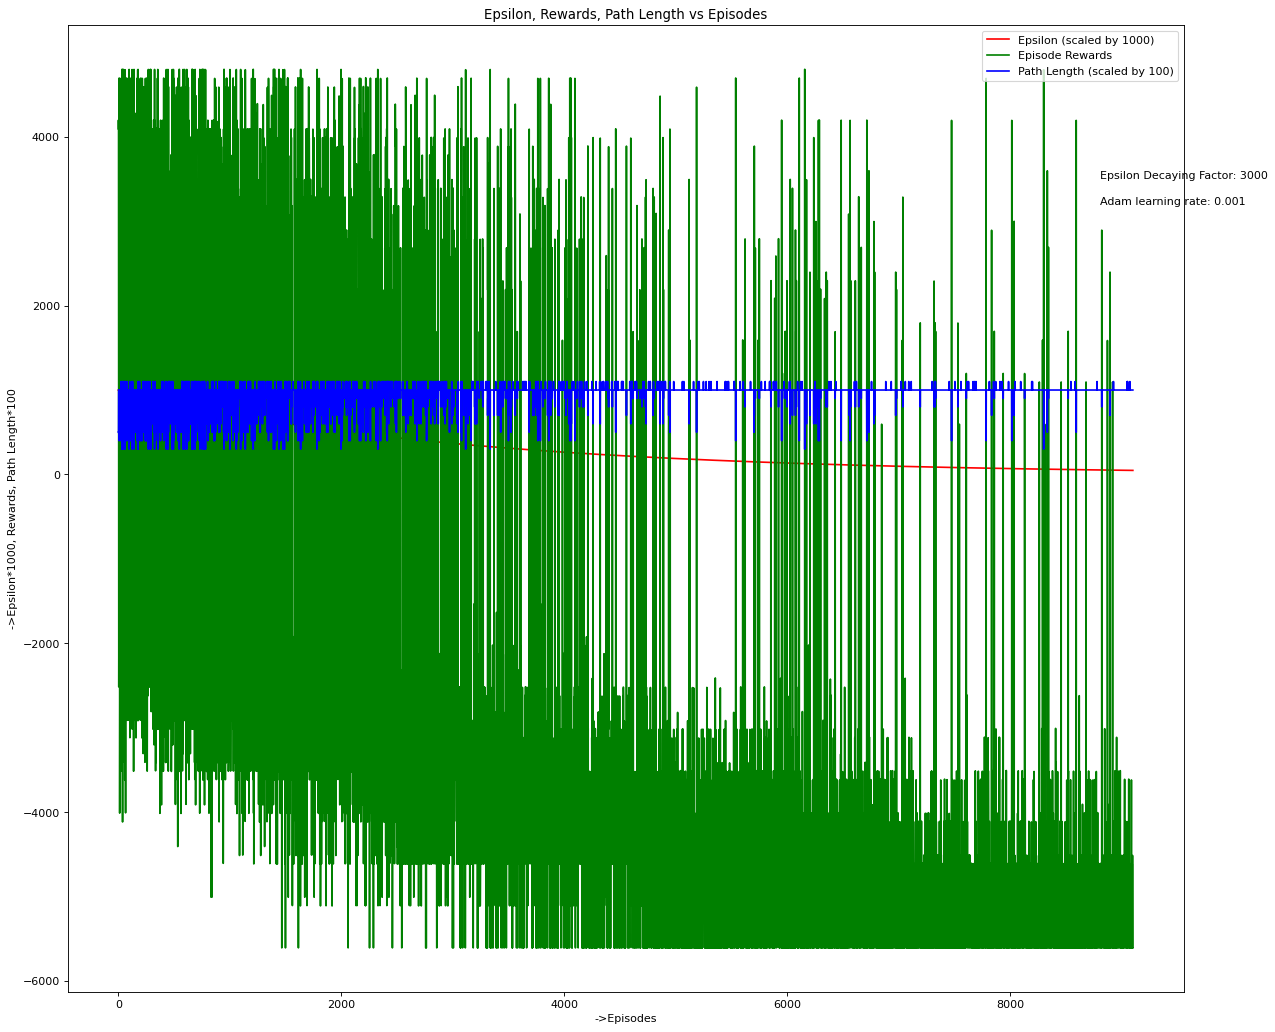

In [79]:
import os
try:
    os.mkdir('saved_plots')
except:
    print("folder is already there")
    
def plot_this(epsilon_list, rewards_list, path_length_list, environment):
    x_axis = list(range(environment.no_of_episodes))
    x_axis = x_axis[:len(path_length_list)]
    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    x_axis = x_axis[:len(epsilon_list)]
    plt.plot(x_axis,epsilon_list,'r', label='Epsilon (scaled by 1000)')
    plt.plot(x_axis,rewards_list,'g', label='Episode Rewards')
    plt.plot(x_axis,path_length_list,'b', label='Path Length (scaled by 100)')
    plt.legend(loc="upper right")
    plt.xlabel('->Episodes')
    plt.ylabel('->Epsilon*1000, Rewards, Path Length*100')
    plt.text(8800, 3500, f'Epsilon Decaying Factor: {epsilon_decaying_factor}')
    plt.text(8800, 3200, f'Adam learning rate: 0.001')
    plt.title('Epsilon, Rewards, Path Length vs Episodes')
plot_this(epsilon_list, rewards_list, path_length_list, environment)
plt.savefig(f'saved_plots/plot_{epsilon_decaying_factor}_min_eps_{environment.min_epsilon}_lr_0.01_discount_{discount}.png')

In [80]:
# Save the entire model as a SavedModel.
import os
# !mkdir -p saved_model
try:
    os.mkdir('saved_models')
except:
    print('already there')
# mm, tm = DQNAgent.get_models()
agent.main_model.save(f'saved_models/main_model_ef_{epsilon_decaying_factor}_mineps_{environment.min_epsilon}_lr_0.01.h5')
agent.target_model.save(f'saved_models/target_model_ef_{epsilon_decaying_factor}_mineps_{environment.min_epsilon}_lr_0.01.h5')

already there


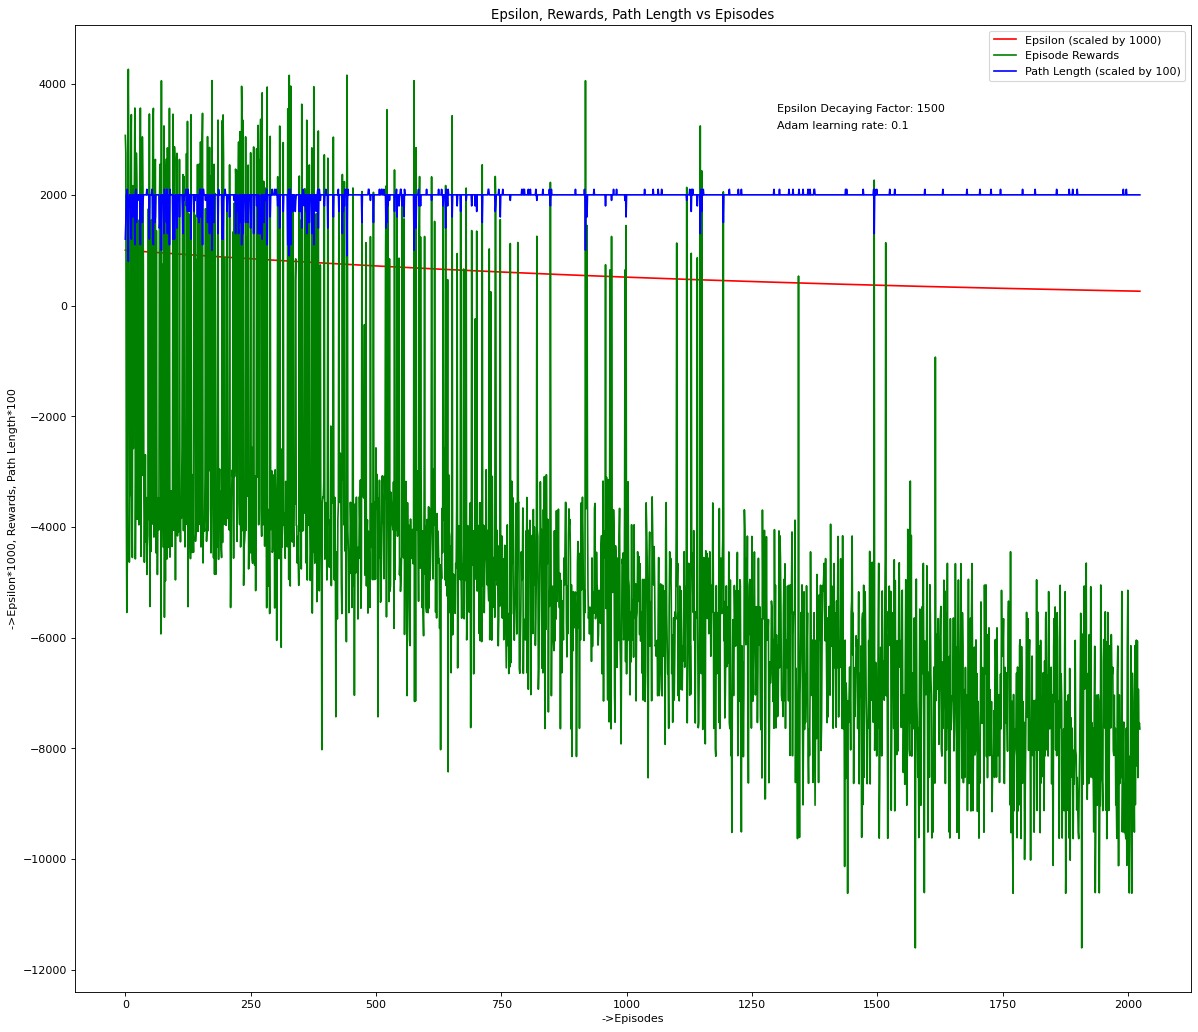

In [72]:
plot_this(epsilon_scaled, rewards_list, path_scaled, environment)

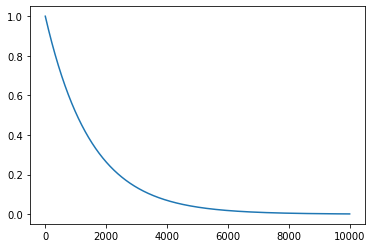

In [119]:
import numpy as np
import matplotlib.pyplot as plt
x = list(range(10000))
# print(x)
k = 1500
y = [float(np.exp(-i/k)) for i in x]
# print(y)
plt.plot(x,y)

In [33]:
class keka:
    def test(self,i):
        return i[1]
    a = [(1,3),(2,1),(3,2)]
    def uppu(self):
        self.a.sort(reverse=True,key=self.test)
        return self.a
    
k = keka()
print(k.uppu())

[(1, 3), (3, 2), (2, 1)]


In [115]:
problem = tsplib95.load_problem('Vrp-All/_singleTruck/A-n32-k5_4.vrp')
len(list(problem.get_nodes()))

5